## Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
from sonar import sonar, utils

In [4]:
rel_kernel_path = 'test/osmFISH' #"."


In [5]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
# 'Endothelial'
]

In [6]:
# n_sample = 1

# # Load the pancreas tissue matrix:

# tissue_matrix = np.load(os.path.join( *rel_kernel_path.split('/'), 'data','sample_matrices.npz'))['sample_'+str(n_sample)]

In [7]:
# Load the coordinates for osmFISH mouse cortex:

import csv

genes,x,y = [],[],[]

header = None
with open (os.path.join( *rel_kernel_path.split('/'), 'data','coordinates.csv')) as file:
    reader = csv.reader(file)
    for row in reader:
        if header is None:
            header = row
        else:
            genes.append(row[0])
            x.append(float(row[1]))
            y.append(float(row[2]))

x = np.array(x).astype(float)
y = np.array(y).astype(float)


gene_categories = list(set(genes))
gene_dict = {gene_categories[i]:i for i in range(len(gene_categories))}
genes = np.array([gene_dict[gene] for gene in genes])


In [8]:
genes

array([27, 27, 27, ...,  8,  8,  8])

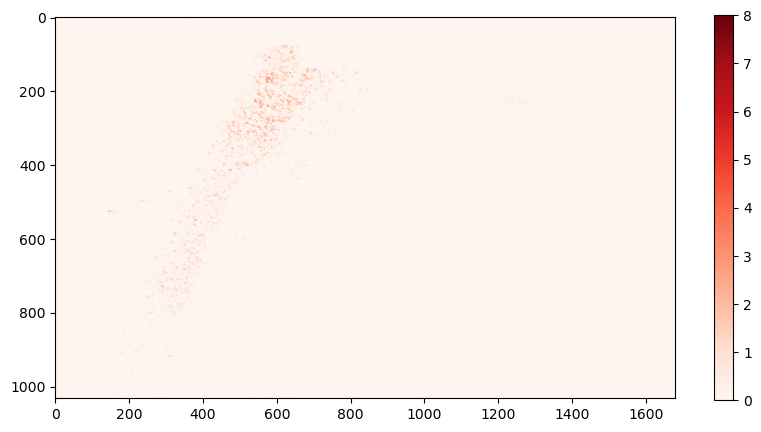

In [9]:
from sonar.utils import PointProcess

point_process = PointProcess(x,y,genes,rescale_factor=0.5,device='cuda')

plt.figure(figsize=(10,5))
plt.imshow(point_process[3].cpu().numpy(),cmap='Reds')
plt.colorbar()

Changing tasks between cpu and gpu

In [11]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'

# unrelated to the NoteBook, the example of a tensor and how to work with it
new_tens = t.zeros(2,2,2, device=device).cuda()
new_tens.device

device(type='cuda', index=0)

In [65]:
rad_ = 50
lin = 50

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)

cooc_template_ = son.co_occurrence_from_tensor(point_process,interpolate=True,normalize=False,progbar=False)


/dh-projects/ag-ishaque/analysis/tiesmeys/src/sonar/sonar/sonar.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kernels = t.tensor(self.kernels,dtype=torch.float32,device=device)


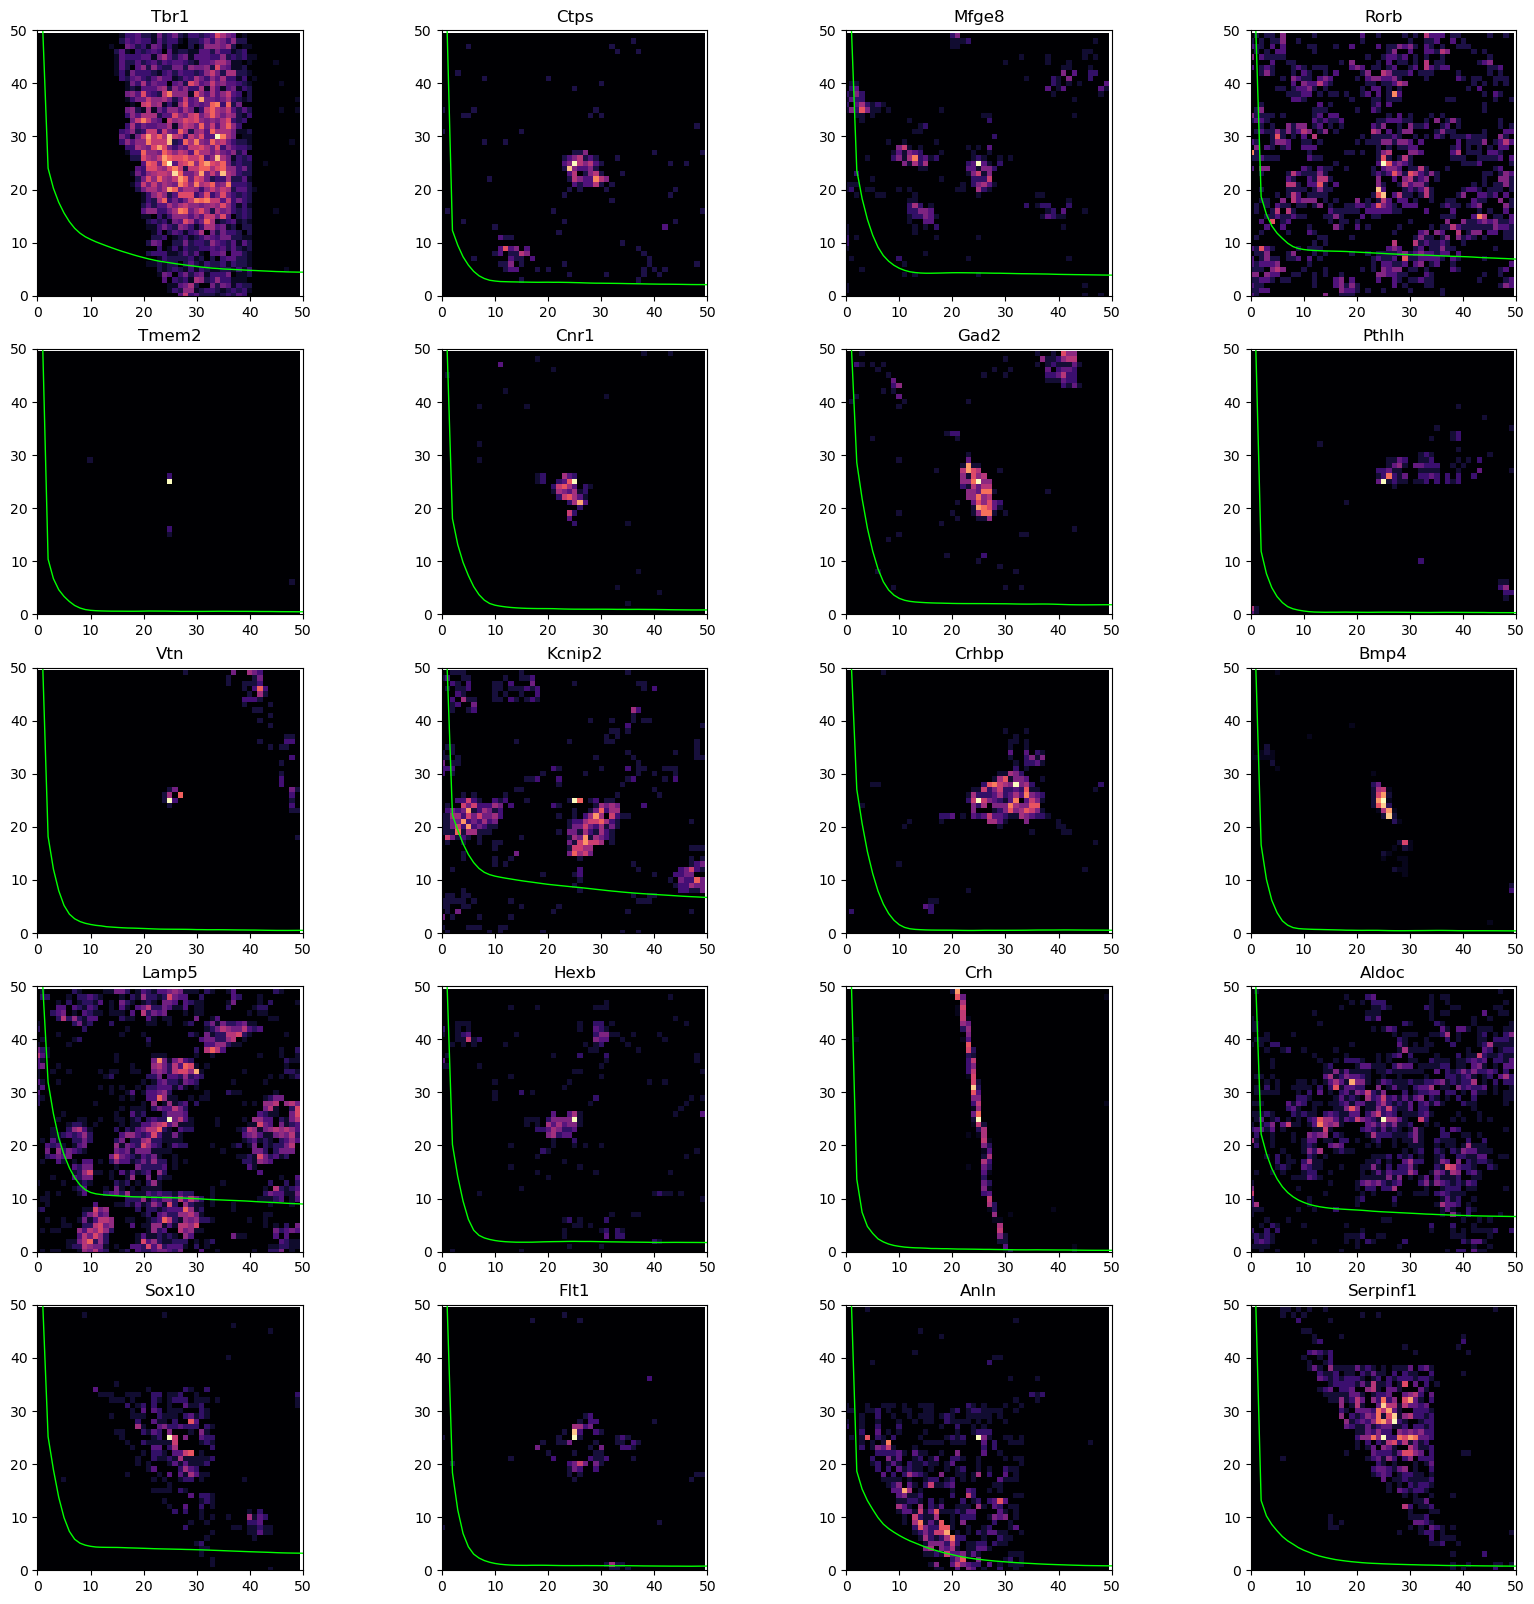

In [67]:
plt.figure(figsize=(20,20))

plot_len = cooc_template_.shape[2]//2

for im in range (20):

    plt.subplot(5,4, im+1) #background excluded

    bg = point_process[im].cpu().numpy()
    x_,y_ = [m[0] for m in np.where(bg[plot_len:-plot_len,plot_len:-plot_len]==bg[plot_len:-plot_len,plot_len:-plot_len].max())]

    bg = bg[x_:x_+plot_len*2,y_:y_+plot_len*2]
    plt.imshow(bg,cmap='magma')


    plotline = cooc_template_[im,im]
    plt.plot(np.linspace(1,bg.shape[1],plotline.shape[0]),plotline/plotline.max()*bg.shape[0],color='lime',linewidth=1)
    plt.title(gene_categories[im])

    plt.gca().invert_yaxis()
    plt.xlim(0,bg.shape[1])
    plt.ylim(0,bg.shape[0])
    # break
